<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/NEW_Div_yld_ATC_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

## **Preparation**

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime


path = os.getcwd()
print(path)

/content


In [3]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-10 03:49:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-10 03:49:22--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-10 03:49:22--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [5]:
import talib 
from talib import abstract

## **ATC strategy**

### ## for single model

In [ ]:
# 新策略
symbol = '006208.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-1-1')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
# equity = pd.DataFrame({'profit':profit_list}, index=timeList)
equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)

equity

In [ ]:
# 實際交易位置
print('buy:{}'.format(buy))
print('win:{}'.format(sell_win))
print('lose:{}'.format(sell_lose))
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'b', label = 'Lose', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

,time,rate
0,2022-01-01 01:00:00+00:00,0.000017
1,2022-01-01 02:00:00+00:00,0.000008
2,2022-01-01 03:00:00+00:00,0.000010
3,2022-01-01 04:00:00+00:00,0.000007
4,2022-01-01 05:00:00+00:00,0.000007
...,...,...
4843,2022-07-21 20:00:00+00:00,-0.000002
4844,2022-07-21 21:00:00+00:00,-0.000008
4845,2022-07-21 22:00:00+00:00,-0.000010
4846,2022-07-21 23:00:00+00:00,-0.000005


In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


### for all

In [ ]:
# 新策略
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 110)
df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['close'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['close'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    
# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

    
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['EMA'] = abstract.EMA(df, timeperiod = 110)
  df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數
  rule = '1H' # hour


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])

          
      

        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['close'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['close'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

,startTime,open,high,low,close,volume
0,2021-01-01 00:00:00+00:00,28956.0,29007.0,28947.0,29000.5,3.000323e+06
1,2021-01-01 00:01:00+00:00,29000.5,29056.0,29000.5,29054.5,1.249483e+06
2,2021-01-01 00:02:00+00:00,29054.0,29054.5,29008.0,29027.0,2.761735e+06
3,2021-01-01 00:03:00+00:00,29027.0,29035.5,29010.5,29018.5,2.916732e+05
4,2021-01-01 00:04:00+00:00,29018.5,29029.0,29010.0,29010.5,6.503414e+05
...,...,...,...,...,...,...
816877,2022-07-22 08:35:00+00:00,23223.0,23247.0,23223.0,23237.0,9.241771e+05
816878,2022-07-22 08:36:00+00:00,23237.0,23274.0,23236.0,23239.0,3.247942e+06
816879,2022-07-22 08:37:00+00:00,23239.0,23252.0,23223.0,23246.0,1.420867e+06
816880,2022-07-22 08:38:00+00:00,23246.0,23316.0,23239.0,23269.0,1.961440e+07


In [ ]:
equity = equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

In [1]:
equity.plot(grid=True, figsize=(12, 6));

NameError: ignored

# **Optimization**

## 濾網：EMA
* result : fast = 17, slow = 38

In [ ]:
# 新策略
opt_list = []


for time in range(30, 101, 10):

  symbol = '0050.TW'
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-1-1')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  print('#####----------#####')
  print(f'period: {time}')

  print(f'---loading: {symbol}---')

  df['EMA'] = abstract.EMA(df, timeperiod = time)
  df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])


        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['open'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['open'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

  ########-------------------------------------------------------------#########

  symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

  for j in range(len(symbol_list)):
    symbol = symbol_list[j]

    print(f'---loading: {symbol}---')

      
    data = yf.Ticker(symbol)
    df = data.history(period='D', start='2008-1-1', end='2022-1-1')
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df['EMA'] = abstract.EMA(df, timeperiod = time)
    df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003
    length = 40 # 均線長度
    stdTimes = 2 # 標準差倍數
    rule = '1H' # hour


    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
            continue

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])   

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        
    # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

    pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
    equity = pd.concat([equity,pp], join='outer', axis=1)

  equity.fillna(0)
  df_ATC = equity.sum(axis = 0)
  ret = df_ATC.mean()
  opt_list.append([time, ret])


In [ ]:
optResult = pd.DataFrame(opt_list, columns=['period','return'])
optResult.sort_values('return', ascending = False)

## 濾網：MACD
* result : fast = 17, slow = 38

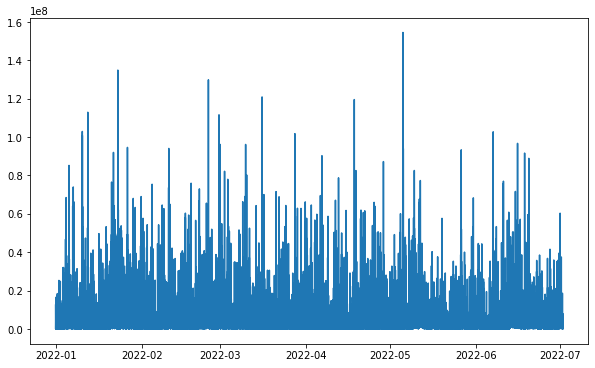

In [ ]:
# 新策略
opt_list = []


for fast in range(5, 20, 2):
  for slow in range(20, 41, 2):

    symbol = '0050.TW'
    data = yf.Ticker(symbol)
    df = data.history(period='D', start='2008-1-1', end='2022-1-1')
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003
    length = 40 # 均線長度
    stdTimes = 2 # 標準差倍數
    rule = '1H' # hour


    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    print('#####----------#####')
    print(f'fast: {fast}')
    print(f'slow: {slow}')

    print(f'---loading: {symbol}---')

    df['EMA'] = abstract.EMA(df, timeperiod = 200)
    df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])

            
            if first == 0:
                timeList.append(df.index[i+1])
                first = 1
            continue

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        
    # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

    equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      print(f'---loading: {symbol}---')

        
      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-6-30')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df['EMA'] = abstract.EMA(df, timeperiod = 200)
      df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
      df['SAR'] = abstract.SAR(df)

      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003
      length = 40 # 均線長度
      stdTimes = 2 # 標準差倍數
      rule = '1H' # hour


      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      #--------# 記錄買入、賣出時間點
      buy = []
      sell = []
      sellshort = []
      buytocover = []
      # stopLoss = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if i == len(df)-1: # last trading day
              break
          
            # buy                                       # BS: position, B: buy, S: sell
          if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
              temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              t = i+1 
              buy.append(t)
              stopLoss = df['SAR'][i]
              stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
              # stopLoss.append(df['close'][i] - df['SAR'][i])

              
              if first == 0:
                  timeList.append(df.index[i+1])
                  first = 1
              continue

            # try 'buy' first 
            # sellshort
          # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
          #     temp = df['open'][i+1]
          #     tempSize = money / temp
          #     BS = 'S'
          #     t = i+1
          #     sellshort.append(t)
              

          #     if first == 0:
          #         timeList.append(df.index[i+1])
          #         first = 1
          #     continue
              
            # buy停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy to cover
          # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
          #     profit = tempSize * (temp - df['open'][i+1])
          #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
          #     profit_fee_list.append(profit_fee)
          #     profit_list.append(profit)
          #     buytocover.append(i+1)
          #     timeList.append(df.index[i])
          #     BS=None
          #     continue
          
          # 可加停利停損在這裡：if......
          
      # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

      pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

    equity.fillna(0)
    df_ATC = equity.sum(axis = 0)
    ret = df_ATC.mean()
    opt_list.append([fast, slow, ret])


Text(0, 0.5, 'volume')

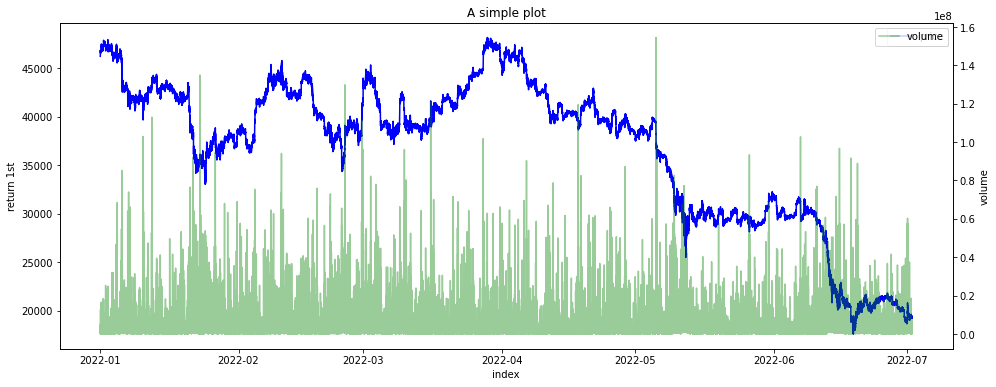

In [ ]:
optResult = pd.DataFrame(opt_list, columns=['fast','slow','return'])
optResult.sort_values('return', ascending = False)

In [ ]:
pic = optResult.pivot('fast', 'slow', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

# 順勢策略最佳解
EMA = 70
MACD : fast = 17, slow = 38

In [ ]:
# 新策略
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 70)
df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if first == 0:
        timeList.append(df.index[i+1])
        first = 1
        continue

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['close'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['close'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    
# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

    
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['EMA'] = abstract.EMA(df, timeperiod = 70)
  df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數
  rule = '1H' # hour


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if first == 0:
          timeList.append(df.index[i+1])
          first = 1
          continue

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['close'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])

          
      

        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['close'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['close'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['close'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

NameError: ignored

# **End**